In [3]:
!unzip counting-cells-in-microscopy-images-2024.zip

Archive:  counting-cells-in-microscopy-images-2024.zip
  inflating: sample_submission.csv   
  inflating: test_images.npz         
  inflating: train_data.npz          


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from skimage import measure
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [5]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder blocks
        self.enc1 = self.contract_block(1, 64)
        self.enc2 = self.contract_block(64, 128)
        self.enc3 = self.contract_block(128, 256)
        self.enc4 = self.contract_block(256, 512)
        # Bottleneck block without pooling
        self.bottleneck = self.contract_block(512, 1024, apply_pooling=False)
        # Decoder blocks
        self.dec4 = self.expand_block(1024, 512)
        self.dec3 = self.expand_block(512, 256)
        self.dec2 = self.expand_block(256, 128)
        self.dec1 = self.expand_block(128, 64)
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1) #Final convolution layer

# Contracting block
    def contract_block(self, in_channels, out_channels, apply_pooling=True, apply_dropout=False):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if apply_dropout:
            layers.append(nn.Dropout(0.5)) # dropout layer
        if apply_pooling:
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2)) # pooling layer
        return nn.Sequential(*layers)

    def expand_block(self, in_channels, out_channels): # Expanding block
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # encoder path
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        bottleneck = self.bottleneck(enc4)
        # decoder path
        dec4 = self.dec4(bottleneck)
        dec3 = self.dec3(dec4)
        dec2 = self.dec2(dec3)
        dec1 = self.dec1(dec2)
        return self.final_conv(dec1)

In [6]:
# Load training and test data
train_data = np.load('train_data.npz')
X_train = train_data['X']
y_train = train_data['y']

test_data = np.load('test_images.npz')
X_test = test_data['X']

In [23]:
print(f"Shape of the first training image: {X_train[0].shape}")
print(f"Shape of the first test image: {X_test[0].shape}")

Shape of the first training image: (128, 128)
Shape of the first test image: (128, 128)


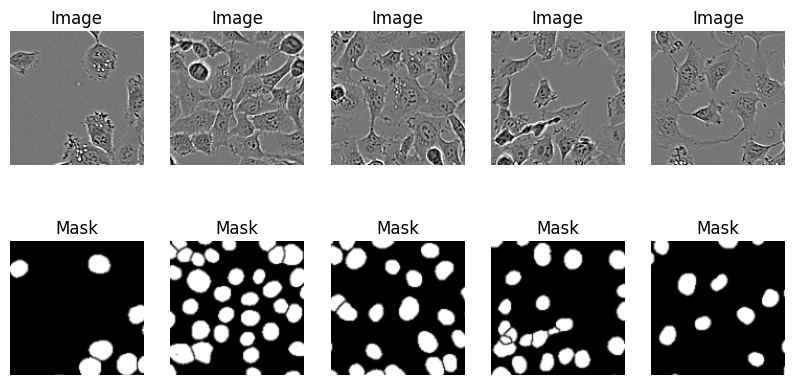

In [20]:
# Visualize
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title('Image')
    plt.axis('off')
    plt.subplot(2, 5, i + 6)
    plt.imshow(y_train[i], cmap='gray')
    plt.title('Mask')
    plt.axis('off')
plt.show()

In [7]:
# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [8]:
# Define the dataset
class CellDataset(Dataset):
    def __init__(self, images, masks=None, train=True):
        self.images = images
        self.masks = masks
        self.train = train
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32)
        image = (image - np.min(image)) / (np.max(image) - np.min(image))  # Normalize the images
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        if self.train:
            mask = self.masks[idx].astype(np.float32)
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
            return image, mask
        else:
            return image

In [9]:
# Create datasets and dataloaders
train_dataset = CellDataset(X_train, y_train, train=True)
val_dataset = CellDataset(X_val, y_val, train=True)
test_dataset = CellDataset(X_test, train=False)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Increased batch size
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)


In [12]:
# Training function for the model
def train_model(num_epochs, train_loader, val_loader):
    model.train()
    history = {'train_loss': [], 'val_loss': []}
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)
        val_loss /= len(val_loader.dataset)
        history['val_loss'].append(val_loss)
        model.train()

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')
        scheduler.step(val_loss)
    return history

# Train the model
num_epochs = 50  # 50 gave the best results
history = train_model(num_epochs, train_loader, val_loader)

Epoch 1/50, Loss: 0.3251, Val Loss: 0.2527
Epoch 2/50, Loss: 0.1862, Val Loss: 0.1813
Epoch 3/50, Loss: 0.1608, Val Loss: 0.1644
Epoch 4/50, Loss: 0.1494, Val Loss: 0.1555
Epoch 5/50, Loss: 0.1420, Val Loss: 0.1641
Epoch 6/50, Loss: 0.1362, Val Loss: 0.1728
Epoch 7/50, Loss: 0.1266, Val Loss: 0.1504
Epoch 8/50, Loss: 0.1213, Val Loss: 0.1451
Epoch 9/50, Loss: 0.1151, Val Loss: 0.1406
Epoch 10/50, Loss: 0.1098, Val Loss: 0.1460
Epoch 11/50, Loss: 0.1054, Val Loss: 0.1559
Epoch 12/50, Loss: 0.0999, Val Loss: 0.1569
Epoch 13/50, Loss: 0.0952, Val Loss: 0.1455
Epoch 14/50, Loss: 0.0864, Val Loss: 0.1516
Epoch 15/50, Loss: 0.0823, Val Loss: 0.1499
Epoch 16/50, Loss: 0.0803, Val Loss: 0.1542
Epoch 17/50, Loss: 0.0786, Val Loss: 0.1557
Epoch 18/50, Loss: 0.0753, Val Loss: 0.1626
Epoch 19/50, Loss: 0.0733, Val Loss: 0.1576
Epoch 20/50, Loss: 0.0719, Val Loss: 0.1605
Epoch 21/50, Loss: 0.0712, Val Loss: 0.1621
Epoch 22/50, Loss: 0.0700, Val Loss: 0.1641
Epoch 23/50, Loss: 0.0694, Val Loss: 0.16

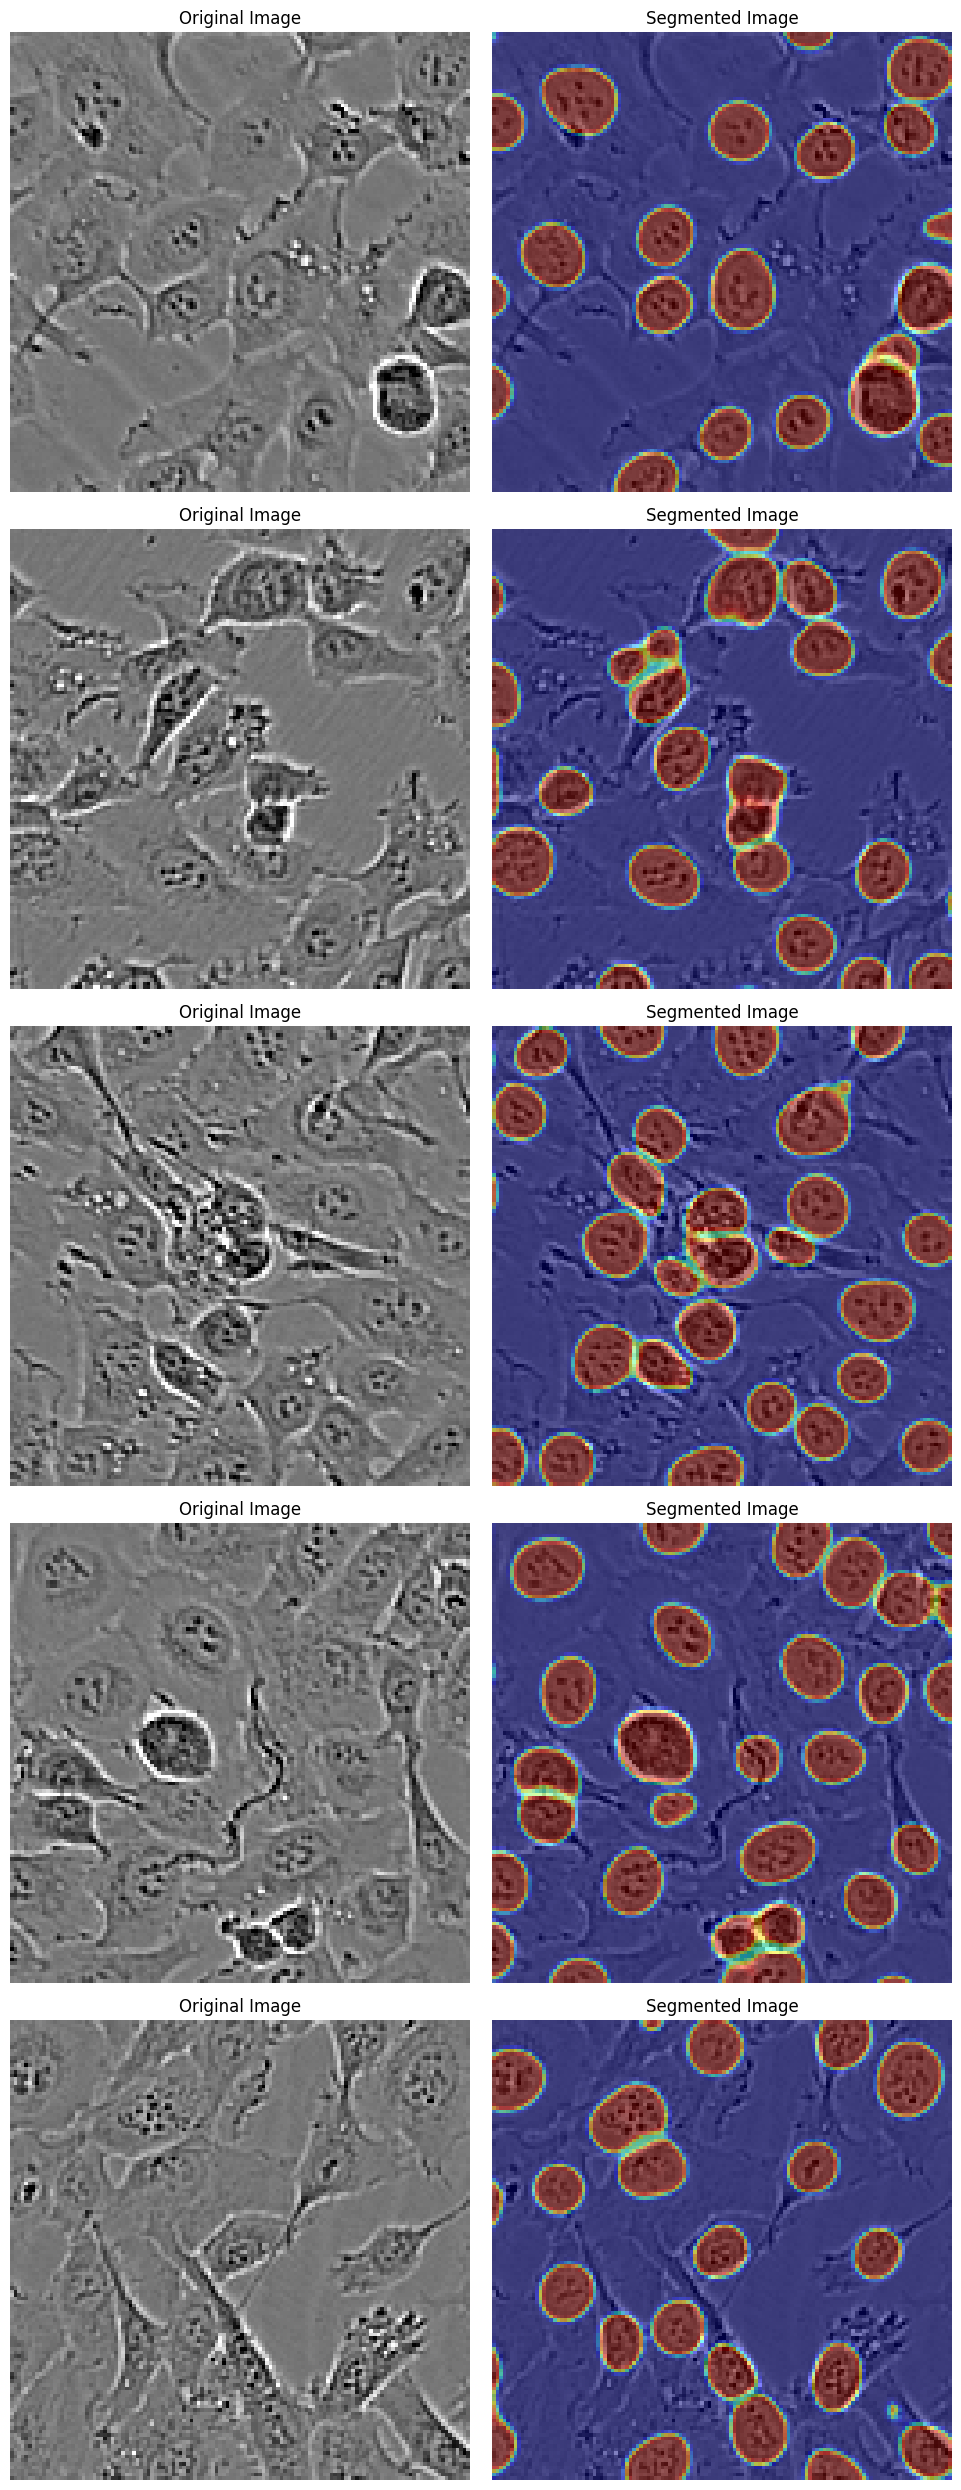

In [16]:
import matplotlib.pyplot as plt

def display_images_with_segmentations(loader, model, num_images=5):
    model.eval()
    images_to_display = min(num_images, len(loader))

    fig, axes = plt.subplots(images_to_display, 2, figsize=(10, images_to_display * 5))

    for i, (images, masks) in enumerate(loader):
        if i >= images_to_display:
            break
        images = images.to(device)
        outputs = model(images)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy()  # sigmoid to convert to probabilities
        images = images.cpu().detach().numpy()
        masks = masks.cpu().detach().numpy()

        for j in range(len(images)):
            img = images[j][0]  # Original image (channel 0)
            pred_mask = outputs[j][0]  # Predicted mask (channel 0)
            true_mask = masks[j][0]  # True mask (channel 0)

            # Plot original image
            axes[i, 0].imshow(img, cmap='gray')
            axes[i, 0].set_title('Original Image')
            axes[i, 0].axis('off')

            # Plot segmented image
            axes[i, 1].imshow(img, cmap='gray')
            axes[i, 1].imshow(pred_mask, cmap='jet', alpha=0.5)
            axes[i, 1].set_title('Segmented Image')
            axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

sample_loader = DataLoader(val_dataset, batch_size=5, shuffle=True)

display_images_with_segmentations(sample_loader, model)


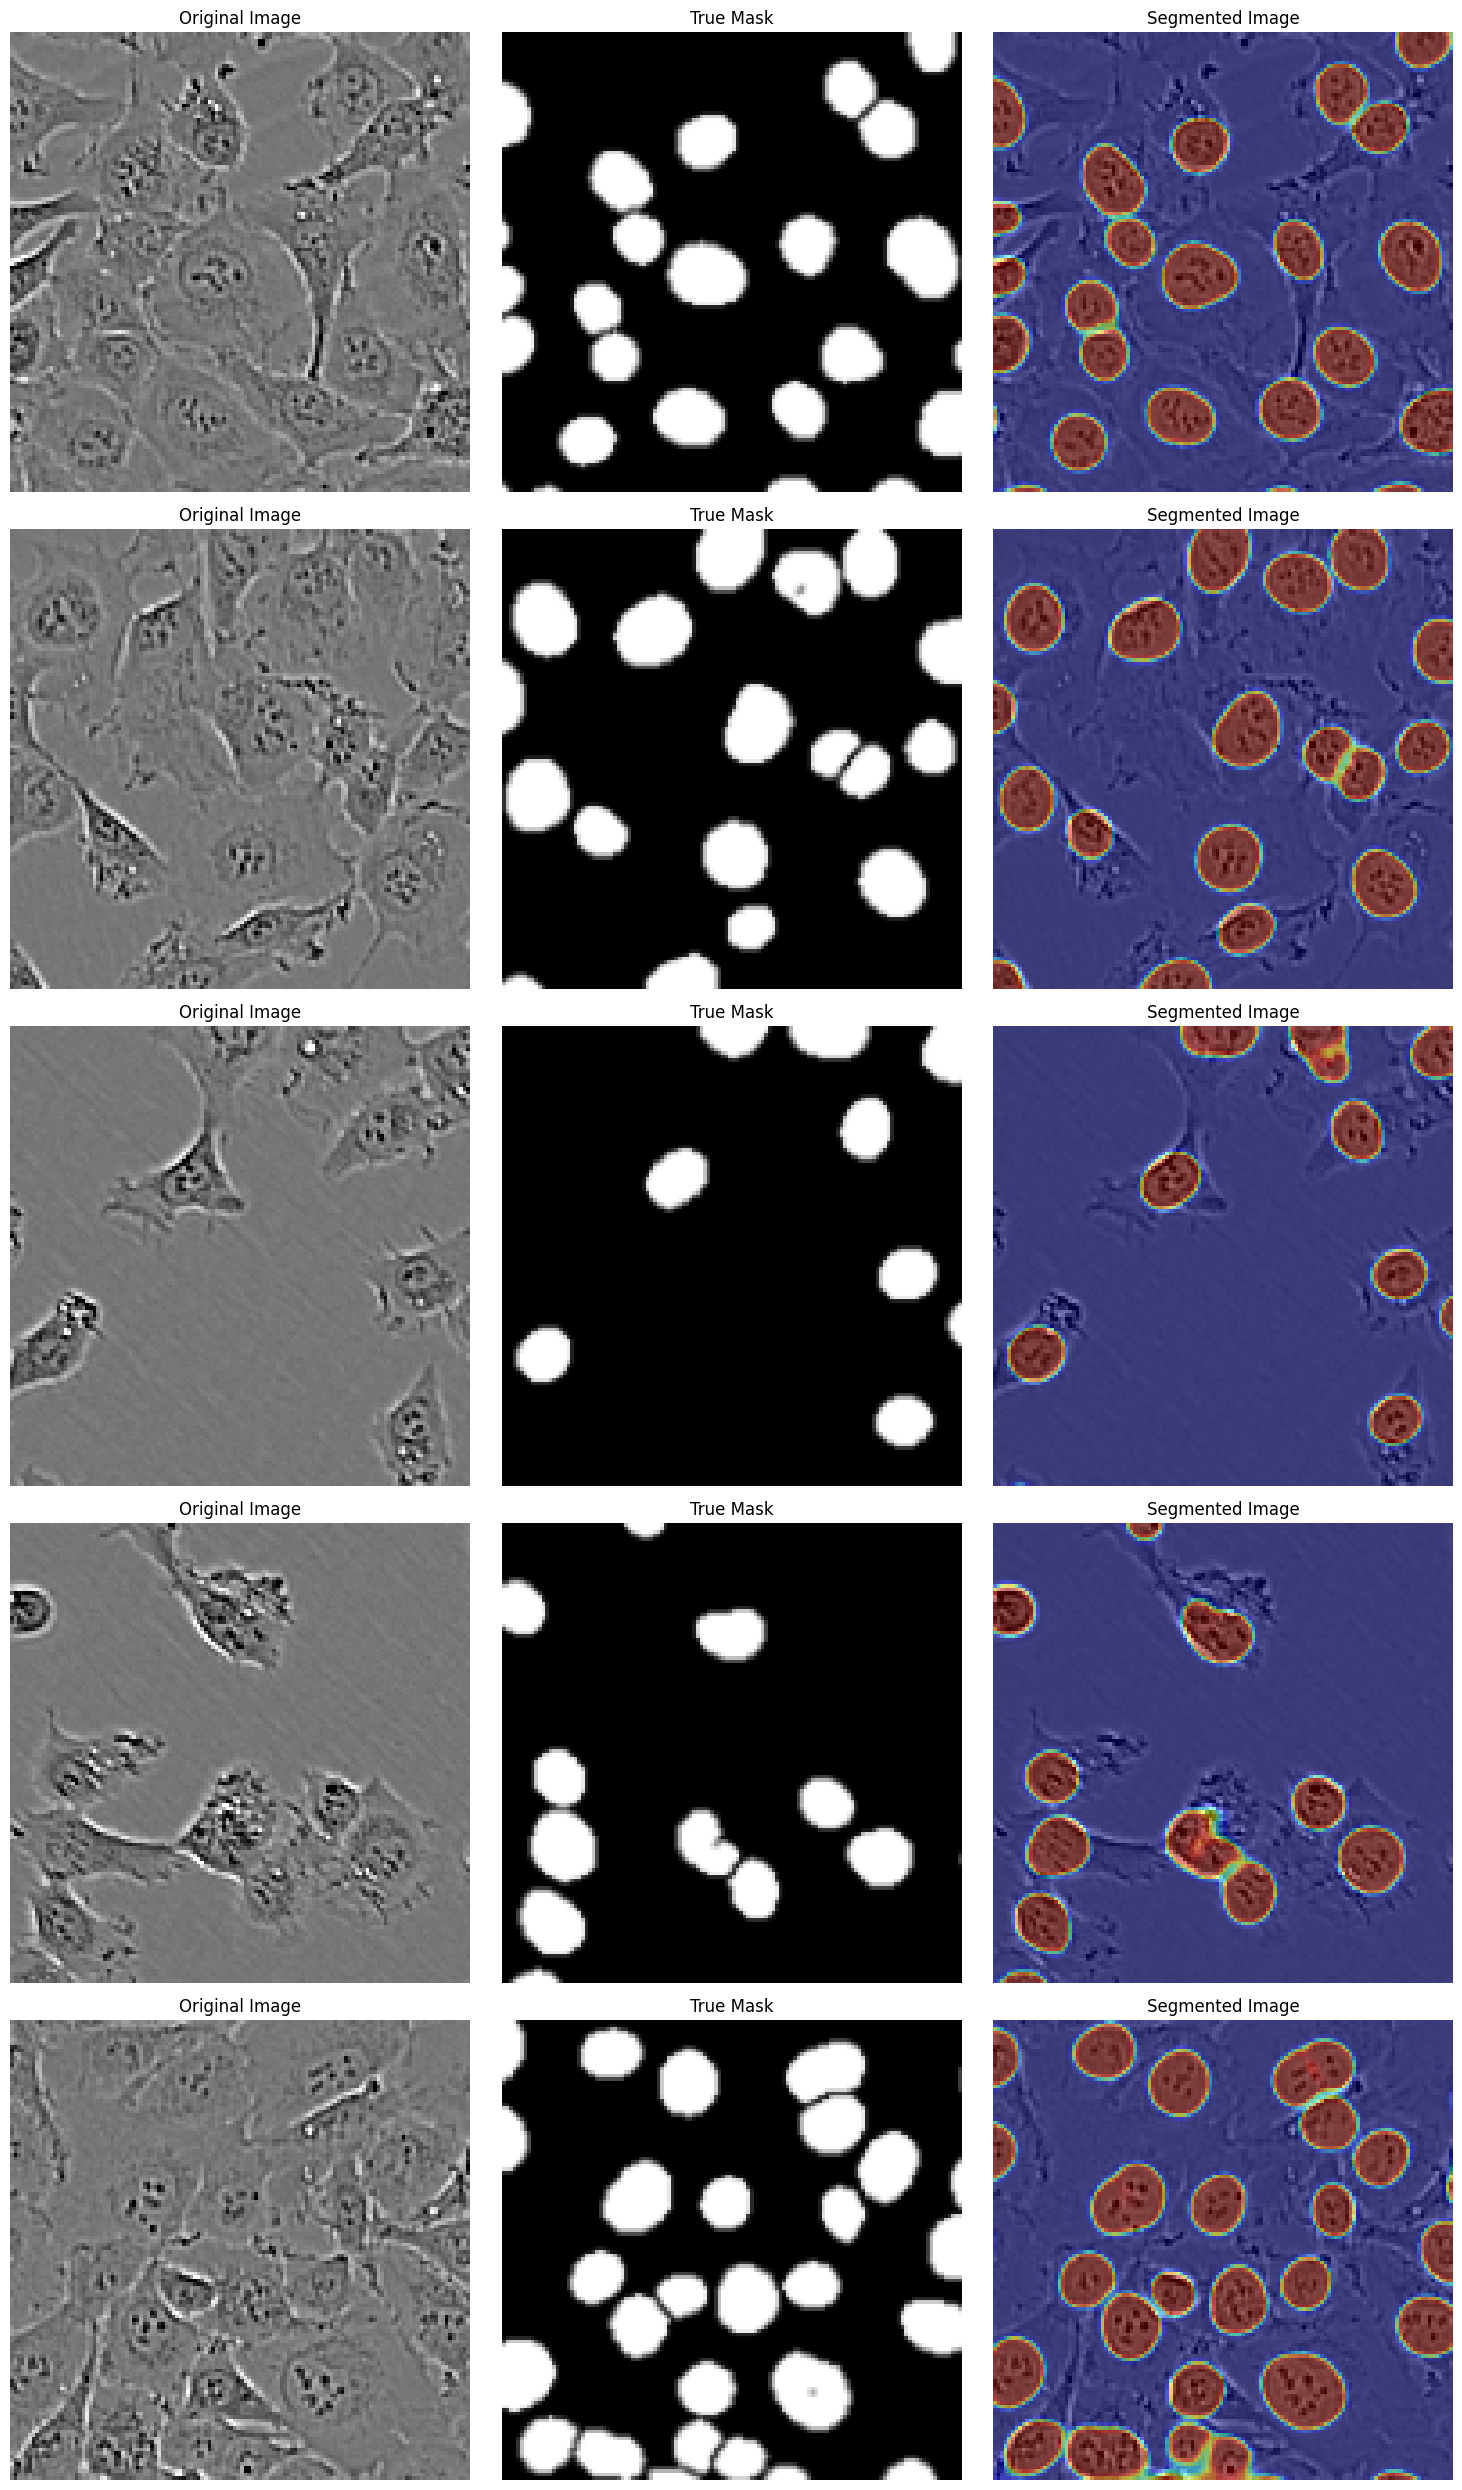

In [18]:
import matplotlib.pyplot as plt

def display_images_with_segmentations(loader, model, num_images=5):
    model.eval()
    images_to_display = min(num_images, len(loader))

    fig, axes = plt.subplots(images_to_display, 3, figsize=(15, images_to_display * 5))

    for i, (images, masks) in enumerate(loader):
        if i >= images_to_display:
            break
        images = images.to(device)
        outputs = model(images)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy()
        images = images.cpu().detach().numpy()
        masks = masks.cpu().detach().numpy()

        for j in range(len(images)):
            img = images[j][0]
            pred_mask = outputs[j][0]
            true_mask = masks[j][0]


            axes[i, 0].imshow(img, cmap='gray')
            axes[i, 0].set_title('Original Image')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(true_mask, cmap='gray')
            axes[i, 1].set_title('True Mask')
            axes[i, 1].axis('off')


            axes[i, 2].imshow(img, cmap='gray')
            axes[i, 2].imshow(pred_mask, cmap='jet', alpha=0.5)
            axes[i, 2].set_title('Segmented Image')
            axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

sample_loader = DataLoader(val_dataset, batch_size=5, shuffle=True)

display_images_with_segmentations(sample_loader, model)


In [13]:
# Prediction and cell counting function
def predict_and_count(loader, model):
    cell_counts = []
    model.eval()
    with torch.no_grad():
        for images in loader:
            images = images.to(device)
            outputs = model(images)
            outputs = torch.sigmoid(outputs)  # Apply sigmoid to convert to probabilities
            predicted_masks = outputs.cpu().numpy() > 0.5  # threshold to get binary masks
            for mask in predicted_masks:
                mask = mask.squeeze()  # remove dimension of channel
                labels = measure.label(mask, background=0)
                cell_count = len(np.unique(labels)) - 1
                cell_counts.append(cell_count)
    return cell_counts

In [14]:
cell_counts = predict_and_count(test_loader, model)
submission_df = pd.DataFrame({
    'index': range(len(cell_counts)),
    'count': cell_counts
})
submission_df.to_csv('updated_submission8.csv', index=False)


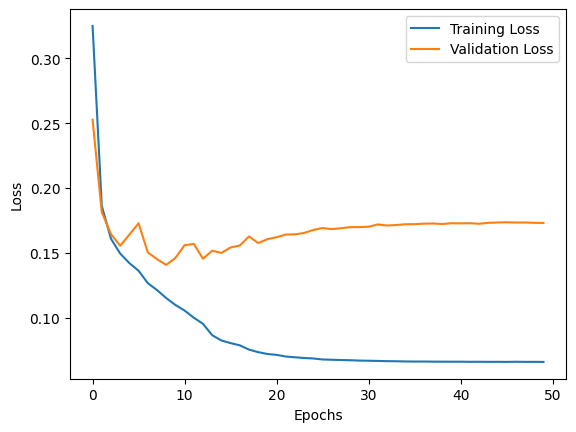

In [15]:
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()